In [29]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [4]:
print('Number of images in the dataset: {}'.format(len(glob.glob('images/*.jpg'))))

Number of images in the dataset: 7390


In [5]:
CATS = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx']
cats_images = []
dogs_images = []

for img in glob.glob('images/*.jpg'):
    if any(cat in img for cat in CATS):
        cats_images.append(img)
    else:
        dogs_images.append(img)
        
print(f"There are {len(cats_images)} cat images")
print(f"There are {len(dogs_images)} dog images")

There are 2400 cat images
There are 4990 dog images


In [6]:
from cProfile import label
from cgi import test


np.random.shuffle(cats_images)
np.random.shuffle(dogs_images)

train_d, val_d, test_d = np.split(dogs_images, [int(len(dogs_images)*0.7), int(len(dogs_images)*0.8)])
train_c, val_c, test_c =np.split(cats_images, [int(len(cats_images)*0.7), int(len(cats_images)*0.8)])


In [7]:
train_dog_df = pd.DataFrame({'image': train_d, 'label': 'dog'})
val_dog_df = pd.DataFrame({'image': val_d, 'label': 'dog'})
test_dog_df = pd.DataFrame({'image': test_d, 'label': 'dog'})

train_cat_df =pd.DataFrame({'image': train_c, 'label': 'cat'})
val_cat_df = pd.DataFrame({'image': val_c, 'label': 'cat'})
test_cat_df = pd.DataFrame({'image': test_c, 'label': 'cat'})

test_dog_df.head()

,image,label
0,images\beagle_35.jpg,dog
1,images\japanese_chin_160.jpg,dog
2,images\scottish_terrier_45.jpg,dog
3,images\havanese_89.jpg,dog
4,images\leonberger_118.jpg,dog


In [8]:
train_df = pd.concat([train_dog_df, train_cat_df])
val_df = pd.concat([val_dog_df, val_cat_df])
test_df = pd.concat([test_dog_df, test_cat_df])

print(f"{len(train_df)} images for training")
print(f"{len(test_df)} images for testing")
print(f"{len(val_df)} images for validation")

5173 images for training
1478 images for testing
739 images for validation


In [9]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

trainGenerator = ImageDataGenerator(rescale=1./225.)
valGenerator = ImageDataGenerator(rescale=1./225.)
testGenerator = ImageDataGenerator(rescale=1./225.)

trainDataset = trainGenerator.flow_from_dataframe(
    dataframe=train_df,
    class_mode="binary",
    x_col="image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

valDataset = valGenerator.flow_from_dataframe(
    dataframe=val_df,
    class_mode="binary",
    x_col="image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)
    
testDataset = testGenerator.flow_from_dataframe(
  dataframe=test_df,
  class_mode='binary',
  x_col="image",
  y_col="label",
  batch_size=BATCH_SIZE,
  seed=42,
  shuffle=True,
  target_size=(IMG_HEIGHT,IMG_WIDTH)
)

Found 5173 validated image filenames belonging to 2 classes.
Found 739 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.


In [10]:
images, labels = next(iter(testDataset))

In [11]:

print('Batch shape: ', images.shape)
print('Label shape: ', labels.shape)

Batch shape:  (32, 224, 224, 3)
Label shape:  (32,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label 1.0


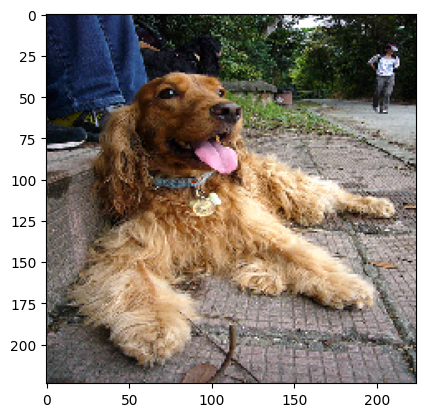

In [12]:
plt.imshow(images[3])
print('Label', labels[3])

In [13]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 256)      0

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
epochs=15
history =model.fit(trainDataset, epochs=epochs, validation_data=(valDataset))

Epoch 1/15
162/162 [==============================] - 597s 4s/step - loss: 0.6119 - accuracy: 0.6727 - val_loss: 0.5874 - val_accuracy: 0.6752
Epoch 2/15
162/162 [==============================] - 607s 4s/step - loss: 0.6066 - accuracy: 0.6749 - val_loss: 0.5836 - val_accuracy: 0.6766
Epoch 3/15
162/162 [==============================] - 524s 3s/step - loss: 0.6081 - accuracy: 0.6808 - val_loss: 0.5833 - val_accuracy: 0.6793
Epoch 4/15
162/162 [==============================] - 524s 3s/step - loss: 0.6005 - accuracy: 0.6793 - val_loss: 0.5874 - val_accuracy: 0.6739
Epoch 5/15
162/162 [==============================] - 526s 3s/step - loss: 0.5836 - accuracy: 0.6868 - val_loss: 0.6028 - val_accuracy: 0.6901
Epoch 6/15
162/162 [==============================] - 524s 3s/step - loss: 0.5744 - accuracy: 0.6951 - val_loss: 0.5761 - val_accuracy: 0.6766
Epoch 7/15
162/162 [==============================] - 531s 3s/step - loss: 0.5673 - accuracy: 0.7052 - val_loss: 0.5796 - val_accuracy: 0.6793

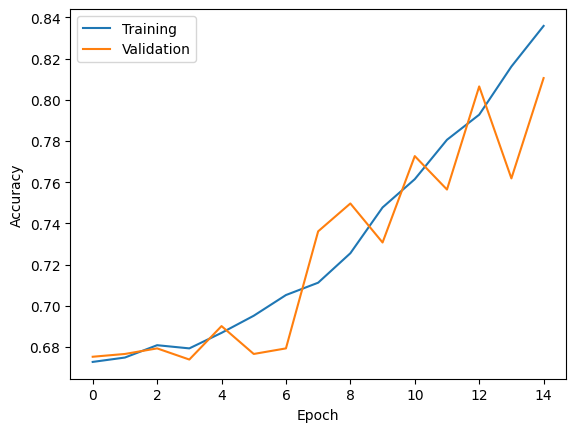

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

In [18]:
loss, acc = model.evaluate(testDataset)

print('Loss', loss)
print('Accuracy:', acc)

47/47 [==============================] - 43s 913ms/step - loss: 0.4483 - accuracy: 0.8153
Loss 0.44826510548591614
Accuracy: 0.8152909278869629


In [19]:
def preprocess(image):
    img_resize = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    img_norm = img_resize / 255
    return img_norm

In [22]:
img = plt.imread('pexels-cat-predict.jpg')
img = tf.reshape(img, (-1, IMG_HEIGHT, IMG_WIDTH, 3))
img = preprocess(img)
model.predict(img)

1/1 [==============================] - 0s 202ms/step


array([[0.48904833]], dtype=float32)

In [25]:
img = plt.imread('230497594_1000.jpg')
img = tf.reshape(img, (-1, IMG_HEIGHT, IMG_WIDTH, 3))
img = preprocess(img)
model.predict(img)

1/1 [==============================] - 0s 114ms/step


array([[0.95884436]], dtype=float32)

AxesImage(80,52.8;496x369.6)
1/1 [==============================] - 0s 55ms/step


array([[0.10751709]], dtype=float32)

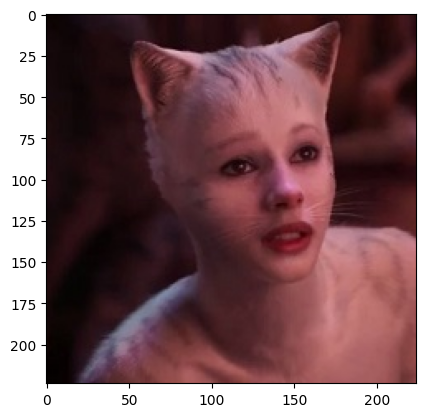

In [32]:
img = plt.imread('cats_movie.jpg')
img = tf.reshape(img, (-1, IMG_HEIGHT, IMG_WIDTH, 3))
img = preprocess(img)
print(plt.imshow(mpimg.imread('cats_movie.jpg')))
model.predict(img)